# Image Classification
- In this file we will do image classification using `pretrain transformer` and fine tune them on our custom dataset.
- We will use this dataset https://www.kaggle.com/datasets/snmahsa/animal-image-dataset-cats-dogs-and-foxes
- We can done this project in 2 form one for without transformer means we can use the pretrain models like vgg or resnet etc  and second we can use the transfomer.

# Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import  transforms
from PIL import Image
import random
import torch
import os

In [2]:
# Load Dataset

In [3]:
!kaggle datasets download -d snmahsa/animal-image-dataset-cats-dogs-and-foxes

Dataset URL: https://www.kaggle.com/datasets/snmahsa/animal-image-dataset-cats-dogs-and-foxes
License(s): other
 96% 373M/388M [00:02<00:00, 122MB/s]
100% 388M/388M [00:03<00:00, 135MB/s]


In [4]:
!unzip animal-image-dataset-cats-dogs-and-foxes.zip

Archive:  animal-image-dataset-cats-dogs-and-foxes.zip
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat001.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat002.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat003.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat004.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat005.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat006.jpg!d  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat007.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat008.svg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat009.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat010.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat011.jpg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat012.jpeg  
  inflating: Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat013

# Data Processing
- Remove Corrupt images.

In [5]:
def remove_corrupt_imges(image_path):
    """
    This function will remove the corrupt images from the dataset.
    """
    try:
        images = os.listdir(image_path)
        for img in images:
            if img.endswith(".jpg") or img.endswith('.png') or img.endswith('.jpeg'):
                img_path = os.path.join(image_path, img)
                img = Image.open(img_path)
                img.verify()
            else:
                os.remove(os.path.join(image_path, img))
                print("Removing Images...",img)
    except Exception as e:
        return e

In [6]:
# Cat Folder
remove_corrupt_imges('/content/Animal Image Dataset-Cats, Dogs, and Foxes/cat')

Removing Images... cat008.svg
Removing Images... cat006.jpg!d


In [7]:
# Dog Folder
remove_corrupt_imges('/content/Animal Image Dataset-Cats, Dogs, and Foxes/dog')

In [8]:
# Fox Folder
remove_corrupt_imges('/content/Animal Image Dataset-Cats, Dogs, and Foxes/fox')

# Data Visulize

In [9]:
def visualize_random_images(image_dir, num_images=10):
    """Visualizes a specified number of random images from a directory."""
    # Get all image files from the directory
    image_files = [
        f for f in os.listdir(image_dir)
        if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    if not image_files:
        print(f"No images found in {image_dir}")
        return

    # Select random image files
    random_image_files = random.sample(image_files, min(num_images, len(image_files)))

    # Calculate grid size for subplots
    grid_size = int(len(random_image_files) ** 0.5) + 1

    plt.figure(figsize=(15, 8))
    for i, image_file in enumerate(random_image_files):
        image_path = os.path.join(image_dir, image_file)
        try:
            # Open and resize the image
            img = Image.open(image_path)
            img = img.resize((224, 224))  # Correct tuple format for resize

            # Add to the subplot
            plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(img)
            plt.title(image_file)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")

    plt.tight_layout()
    plt.show()


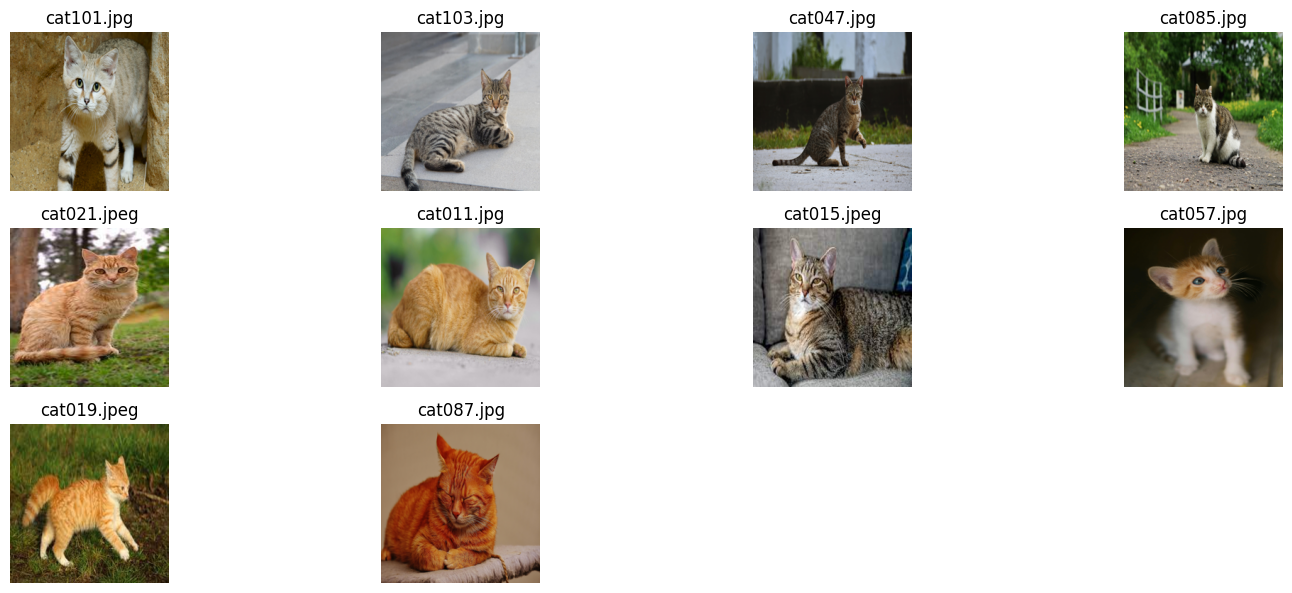

In [31]:
visualize_random_images('/content/Animal Image Dataset-Cats, Dogs, and Foxes/cat')

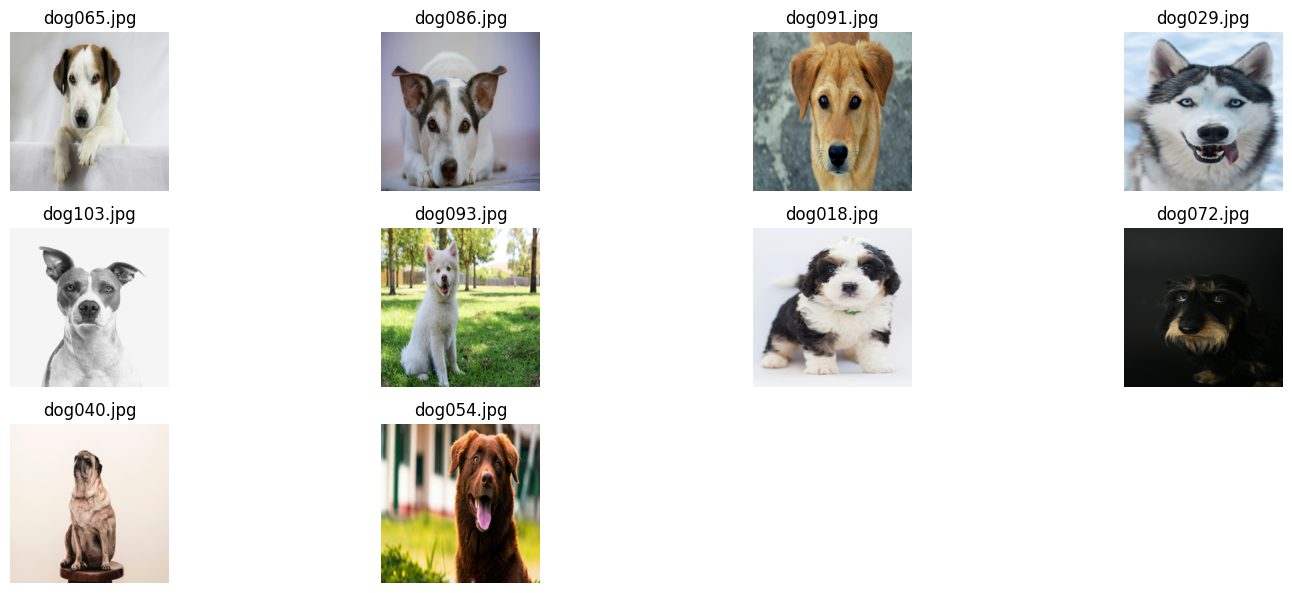

In [32]:
visualize_random_images('/content/Animal Image Dataset-Cats, Dogs, and Foxes/dog')

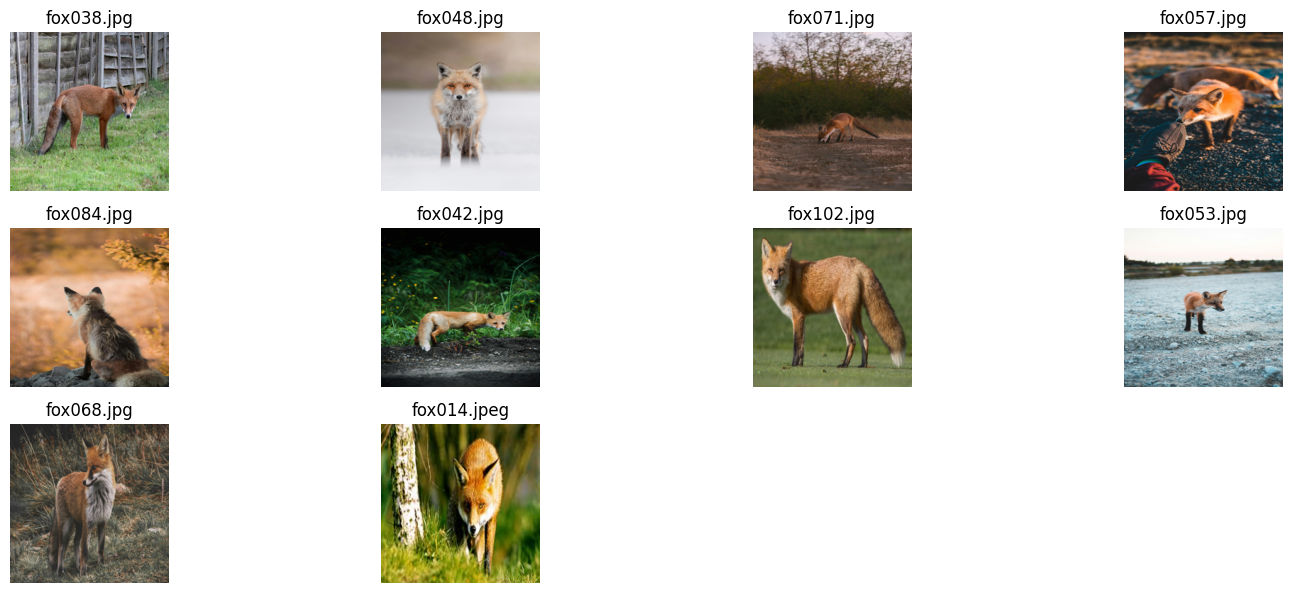

In [34]:
visualize_random_images('/content/Animal Image Dataset-Cats, Dogs, and Foxes/fox')

# Our Observation
- First we can make a custom data loader with custom transformation.
- Second we cna use the pretrain vision transformer and feature extractor.

In [10]:
# Custom Data Transformation

In [5]:
class CustomData(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []


        for idx,label in enumerate(self.classes):
            img_path = os.path.join(root_dir,label)
            for img in os.listdir(img_path):
                self.image_paths.append(os.path.join(img_path,img))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        # get the image and id from the given index
        img_path = self.image_paths[idx]
        img_label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            transform_img = self.transform(image)

        return transform_img,img_label

In [6]:
# make the transformation
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data = CustomData('/content/Animal Image Dataset-Cats, Dogs, and Foxes',transform=transform)
data

# Split Data

In [13]:
from sklearn.model_selection import train_test_split

train_size = 0.8
train_data, test_data = train_test_split(data, train_size=train_size, random_state=42) # random_state for reproducibility

In [14]:
# Make a dataloader
train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

In [15]:
# View the single batch of images
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [16]:
# Visulaize the batch of image

In [16]:
def visualize_batch(images, labels, classes=None):
    """Visualizes a batch of images with their corresponding labels."""
    batch_size = images.shape[0]
    grid_size = int(batch_size**0.5) + 1  # Adjust grid size dynamically

    plt.figure(figsize=(15, 8))
    for i in range(batch_size):
        image = images[i].permute(1, 2, 0).numpy()  # Reshape and convert to NumPy
        image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(image)

        label = labels[i].item()  # Get the label value
        if classes is not None and 0 <= label < len(classes):
            plt.title(f"Label: {classes[label]}")
        else:
          plt.title(f"Label: {label}")

        plt.axis('off')

    plt.tight_layout()
    plt.show()

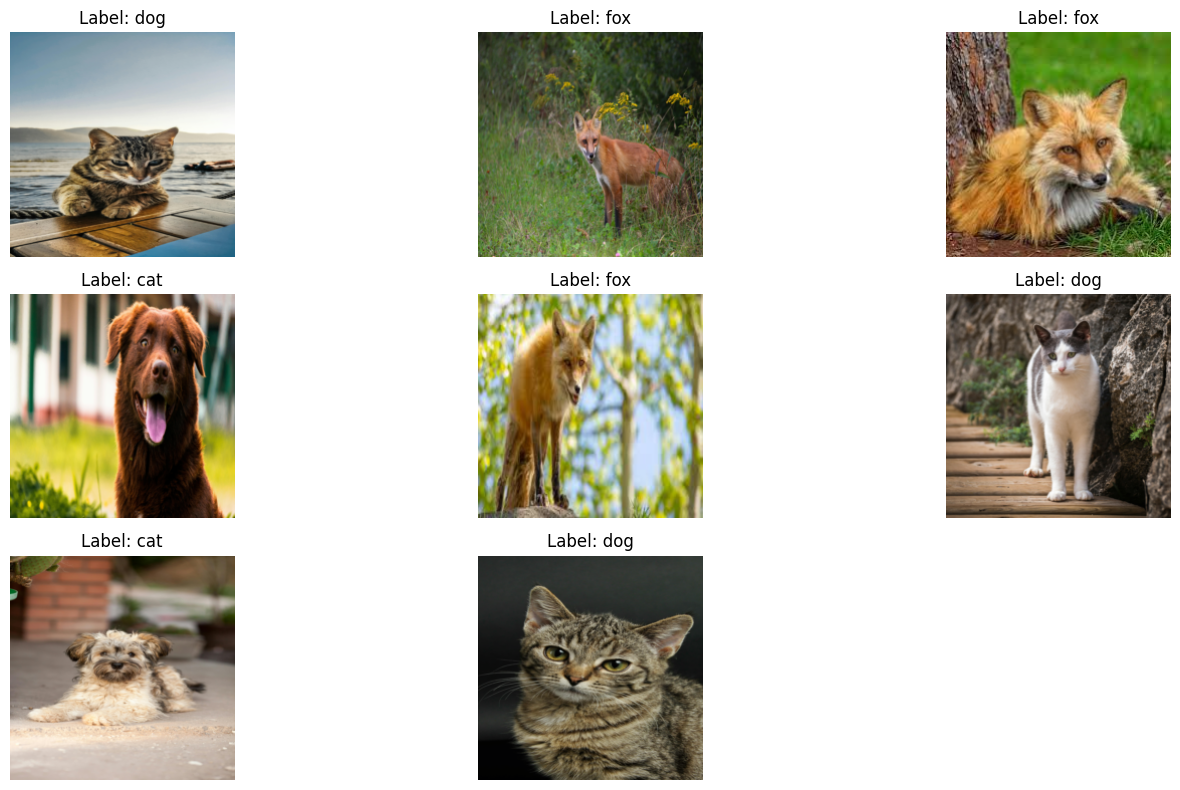

In [19]:
# Set the classes
classes = ['cat', 'dog', 'fox'] # replace with your actual classes

for images, labels in train_loader:
    visualize_batch(images, labels, classes)  # visualize with class names if available
    break

In [7]:
import torchvision.models as models

In [18]:
# Load the pre-trained VGG16 model
base_model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.1MB/s]


In [19]:
# freeze the layers
for param in base_model.parameters():
    param.requires_grad = False

In [20]:
# Modify the classification head
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
# Modify the classifier head
base_model.classifier[6] =  nn.Linear(4096, 3)

In [22]:
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
for params in base_model.classifier.parameters():
    params.requires_grad = True

In [24]:
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# Set the loss fun and optimizer
from torch.optim import Adam

epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters(),lr=0.0001)

loss_fn, optimizer, epochs

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0001
     maximize: False
     weight_decay: 0
 ),
 5)

# Model Training
- Now we can train the model in a single batch so that we can check the model performace

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred):
    """
    Computes accuracy, precision, recall, and F1-score.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.

    Returns:
        A dictionary containing the computed metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted') # Use 'weighted' for multi-class
    recall = recall_score(y_true, y_pred, average='weighted') # Use 'weighted' for multi-class
    f1 = f1_score(y_true, y_pred, average='weighted') # Use 'weighted' for multi-class

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

In [41]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Move the model to the device before the epoch loop
model = base_model.to(device)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        y_pred = model(images)

        # Calculate the loss
        loss = loss_fn(y_pred, labels)

        # Backward pass
        optimizer.zero_grad()  # Zero the gradients before backpropagation
        loss.backward()  # Backpropagation

        # Update model parameters
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(y_pred, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        break

    # Compute training metrics
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss/len(train_loader):.4f} - Training Accuracy: {train_accuracy:.2f}%")

    # Evaluation loop
    with torch.no_grad():
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        for images, labels in tqdm(test_loader, desc=f"Evaluating Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Track loss and accuracy
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            break
        # Compute test metrics
        test_accuracy = 100 * correct_test / total_test
        print(f"Epoch {epoch+1}/{epochs} - Test Loss: {test_loss/len(test_loader):.4f} - Test Accuracy: {test_accuracy:.2f}%")

print("Training complete!")


Training Epoch 1/5:   0%|          | 0/8 [00:01<?, ?it/s]


Epoch 1/5 - Training Loss: 0.1645 - Training Accuracy: 25.00%


Evaluating Epoch 1/5:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1/5 - Test Loss: 0.4397 - Test Accuracy: 81.25%


Training Epoch 2/5:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 2/5 - Training Loss: 0.1059 - Training Accuracy: 65.62%


Evaluating Epoch 2/5:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 2/5 - Test Loss: 0.3302 - Test Accuracy: 93.75%


Training Epoch 3/5:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 3/5 - Training Loss: 0.0882 - Training Accuracy: 75.00%


Evaluating Epoch 3/5:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 3/5 - Test Loss: 0.2405 - Test Accuracy: 100.00%


Training Epoch 4/5:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 4/5 - Training Loss: 0.0524 - Training Accuracy: 93.75%


Evaluating Epoch 4/5:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 4/5 - Test Loss: 0.1760 - Test Accuracy: 100.00%


Training Epoch 5/5:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 5/5 - Training Loss: 0.0331 - Training Accuracy: 93.75%


Evaluating Epoch 5/5:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/5 - Test Loss: 0.1272 - Test Accuracy: 100.00%
Training complete!


# Now train the model on full data.

In [43]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, model=None, save_path=None):
        """
        Initialize the EarlyStopping class.

        Args:
        - patience (int): How many epochs to wait after the last improvement.
        - min_delta (float): Minimum change in the monitored metric to qualify as an improvement.
        - model (torch.nn.Module): The model to save if a new best is achieved (optional).
        - save_path (str): Path to save the best model (optional).
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model = model
        self.save_path = save_path

    def __call__(self, val_loss):
        """
        Check if early stopping should be triggered.

        Args:
        - val_loss (float): The current validation loss.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.model and self.save_path:
                self._save_checkpoint()
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.model and self.save_path:
                self._save_checkpoint()
        else:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print("INFO: Early stopping triggered.")
                self.early_stop = True

    def _save_checkpoint(self):
        """
        Save the model checkpoint to the specified path.
        """
        print(f"INFO: Validation loss improved. Saving model to {self.save_path}")
        torch.save(self.model.state_dict(), self.save_path)

In [31]:
# Move the model to the device before the epoch loop
model = base_model.to(device)

# Initialize metrics storage
full_train_loss = []
full_test_loss = []
full_train_acc = []
full_test_acc = []

# Initialize EarlyStopping with model saving
early_stopping = EarlyStopping(
    patience=3,
    min_delta=0.001,
    model=model,
    save_path="best_model.pth"
)

for epoch in range(10):  # Fixed epochs count
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/10"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        y_pred = model(images)

        # Calculate the loss
        loss = loss_fn(y_pred, labels)

        # Backward pass
        optimizer.zero_grad()  # Zero the gradients before backpropagation
        loss.backward()  # Backpropagation

        # Update model parameters
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(y_pred, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Compute epoch-wise training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    full_train_loss.append(avg_train_loss)
    full_train_acc.append(train_accuracy)
    print(f"Epoch {epoch+1}/10 - Training Loss: {avg_train_loss:.4f} - Training Accuracy: {train_accuracy:.2f}%")

    # Evaluation loop
    with torch.no_grad():
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        for images, labels in tqdm(test_loader, desc=f"Evaluating Epoch {epoch+1}/10"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Track loss and accuracy
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        # Compute epoch-wise test metrics
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        full_test_loss.append(avg_test_loss)
        full_test_acc.append(test_accuracy)
        print(f"Epoch {epoch+1}/10 - Test Loss: {avg_test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")

        # Early stopping
        early_stopping(avg_test_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Ending training.")
            break

print("Training complete!")

Training Epoch 1/10: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


Epoch 1/10 - Training Loss: 0.0747 - Training Accuracy: 98.37%


Evaluating Epoch 1/10: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Epoch 1/10 - Test Loss: 0.0316 - Test Accuracy: 100.00%
INFO: Validation loss improved. Saving model to best_model.pth


Training Epoch 2/10: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch 2/10 - Training Loss: 0.0102 - Training Accuracy: 99.59%


Evaluating Epoch 2/10: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Epoch 2/10 - Test Loss: 0.0102 - Test Accuracy: 100.00%
INFO: Validation loss improved. Saving model to best_model.pth


Training Epoch 3/10: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch 3/10 - Training Loss: 0.0003 - Training Accuracy: 100.00%


Evaluating Epoch 3/10: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Epoch 3/10 - Test Loss: 0.0106 - Test Accuracy: 100.00%
INFO: Early stopping counter 1 of 3


Training Epoch 4/10: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


Epoch 4/10 - Training Loss: 0.0001 - Training Accuracy: 100.00%


Evaluating Epoch 4/10: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Epoch 4/10 - Test Loss: 0.0126 - Test Accuracy: 100.00%
INFO: Early stopping counter 2 of 3


Training Epoch 5/10: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Epoch 5/10 - Training Loss: 0.0001 - Training Accuracy: 100.00%


Evaluating Epoch 5/10: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

Epoch 5/10 - Test Loss: 0.0126 - Test Accuracy: 100.00%
INFO: Early stopping counter 3 of 3
INFO: Early stopping triggered.
Early stopping triggered. Ending training.
Training complete!


# Load the Model and do prediction

In [8]:
def prediction(model,image_path,device):
    img =Image.open(image_path)
    img = img.resize((224,224))
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_tensor)
        pred = pred.argmax(dim=1).item()
    return pred

In [9]:
# load the save model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=False) # Load without pretrained weights
model.classifier[6] = torch.nn.Linear(4096, 3) # Set the correct classifier head

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-9-2eb95bba335d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
image_path = "/content/cat.jpg"
predicted_class = prediction(model, image_path,device)
print(f"Predicted class: {predicted_class}")

Predicted class: 2


In [13]:
image_path = "/content/Animal Image Dataset-Cats, Dogs, and Foxes/cat/cat004.jpg"
predicted_class = prediction(model, image_path,device)
print(f"Predicted class: {predicted_class}")

Predicted class: 2


In [11]:
image_path = "/content/dog.jpeg"
predicted_class = prediction(model, image_path,device)
print(f"Predicted class: {predicted_class}")

Predicted class: 1


In [14]:
image_path = "/content/Animal Image Dataset-Cats, Dogs, and Foxes/dog/dog006.jpeg"
predicted_class = prediction(model, image_path,device)
print(f"Predicted class: {predicted_class}")

Predicted class: 1


In [12]:
image_path = "/content/fox.jpeg"
predicted_class = prediction(model, image_path,device)
print(f"Predicted class: {predicted_class}")

Predicted class: 0


In [15]:
image_path = "/content/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox005.jpg"
predicted_class = prediction(model, image_path,device)
print(f"Predicted class: {predicted_class}")

Predicted class: 0


# Observation
- Now we will done with `Vgg16` Modle to train the model on custom dataset.
- Now we will use the transformer model and transformer feature extractore and we will ttrain the model again.

# Tranaformer Model

# Load the transformer model and transformer feature extractor

In [21]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [23]:
num_labels = len(os.listdir("/content/Animal Image Dataset-Cats, Dogs, and Foxes"))
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Test the processor
img = Image.open("/content/dog.jpeg")
img
img_patches = processor(img, return_tensors="pt")
img_patches

{'pixel_values': tensor([[[[0.8353, 0.8353, 0.8353,  ..., 0.8980, 0.8980, 0.8980],
          [0.8353, 0.8353, 0.8353,  ..., 0.8980, 0.8980, 0.8980],
          [0.8353, 0.8353, 0.8353,  ..., 0.8980, 0.8980, 0.8980],
          ...,
          [0.6235, 0.6235, 0.6235,  ..., 0.8667, 0.8667, 0.8667],
          [0.6235, 0.6235, 0.6235,  ..., 0.8667, 0.8667, 0.8667],
          [0.6235, 0.6235, 0.6235,  ..., 0.8667, 0.8667, 0.8667]],

         [[0.8353, 0.8353, 0.8353,  ..., 0.8980, 0.8980, 0.8980],
          [0.8353, 0.8353, 0.8353,  ..., 0.8980, 0.8980, 0.8980],
          [0.8353, 0.8353, 0.8353,  ..., 0.8980, 0.8980, 0.8980],
          ...,
          [0.6235, 0.6235, 0.6235,  ..., 0.8667, 0.8667, 0.8667],
          [0.6235, 0.6235, 0.6235,  ..., 0.8667, 0.8667, 0.8667],
          [0.6235, 0.6235, 0.6235,  ..., 0.8667, 0.8667, 0.8667]],

         [[0.8353, 0.8353, 0.8353,  ..., 0.8980, 0.8980, 0.8980],
          [0.8353, 0.8353, 0.8353,  ..., 0.8980, 0.8980, 0.8980],
          [0.8353, 0.8353

In [24]:
img_patches.keys()

dict_keys(['pixel_values'])

In [25]:
img_patches['pixel_values'].shape

torch.Size([1, 3, 224, 224])

# Custom Data For transformer model

In [34]:
class CustomData(Dataset):
    def __init__(self,root_dir):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []


        for idx,label in enumerate(self.classes):
            img_path = os.path.join(root_dir,label)
            for img in os.listdir(img_path):
                self.image_paths.append(os.path.join(img_path,img))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        # get the image and id from the given index
        img_path = self.image_paths[idx]
        img_label = self.labels[idx]

        img_patches = self.processor(img_path)
        return img_patches['pixel_values'].squeeze(0),img_label

    def processor(self,img_path):
        img = Image.open(img_path).convert("RGB")
        img_patches = processor(img, return_tensors="pt")
        return img_patches

In [35]:
data = CustomData(root_dir="/content/Animal Image Dataset-Cats, Dogs, and Foxes")
data

In [36]:
# Make a dataloader
from sklearn.model_selection import train_test_split

train_size = 0.8
train_data, test_data = train_test_split(data, train_size=train_size, random_state=42) # random_state for reproducibility

In [59]:
train_loader = DataLoader(train_data,batch_size=2,shuffle=True)
test_loader = DataLoader(test_data,batch_size=2,shuffle=False)

In [53]:
# set the optimizer and loss
# Set the loss fun and optimizer
from torch.optim import Adam

epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=5e-5)

loss_fn, optimizer, epochs

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 5e-05
     maximize: False
     weight_decay: 0
 ),
 10)

# Train the model

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
# Move the model to the device before the epoch loop
model = model.to(device)

# Initialize metrics storage
full_train_loss = []
full_test_loss = []
full_train_acc = []
full_test_acc = []

# Initialize EarlyStopping with model saving
early_stopping = EarlyStopping(
    patience=3,
    min_delta=0.001,
    model=model,
    save_path="best_model.pth"
)

for epoch in range(10):  # Fixed epochs count
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/10"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        y_pred = model(images)

        # Calculate the loss
        loss = loss_fn(y_pred.logits, labels)

        # Backward pass
        optimizer.zero_grad()  # Zero the gradients before backpropagation
        loss.backward()  # Backpropagation

        # Update model parameters
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(y_pred.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Compute epoch-wise training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    full_train_loss.append(avg_train_loss)
    full_train_acc.append(train_accuracy)
    print(f"Epoch {epoch+1}/10 - Training Loss: {avg_train_loss:.4f} - Training Accuracy: {train_accuracy:.2f}%")

    # Evaluation loop
    with torch.no_grad():
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        for images, labels in tqdm(test_loader, desc=f"Evaluating Epoch {epoch+1}/10"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs.logits, labels)

            # Track loss and accuracy
            test_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        # Compute epoch-wise test metrics
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        full_test_loss.append(avg_test_loss)
        full_test_acc.append(test_accuracy)
        print(f"Epoch {epoch+1}/10 - Test Loss: {avg_test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")

        # Early stopping
        early_stopping(avg_test_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Ending training.")
            break

print("Training complete!")

Training Epoch 1/10: 100%|██████████| 123/123 [00:12<00:00,  9.60it/s]


Epoch 1/10 - Training Loss: 0.1857 - Training Accuracy: 95.53%


Evaluating Epoch 1/10: 100%|██████████| 31/31 [00:00<00:00, 34.19it/s]


Epoch 1/10 - Test Loss: 0.0801 - Test Accuracy: 96.77%
INFO: Validation loss improved. Saving model to best_model.pth


Training Epoch 2/10: 100%|██████████| 123/123 [00:12<00:00,  9.74it/s]


Epoch 2/10 - Training Loss: 0.0182 - Training Accuracy: 99.59%


Evaluating Epoch 2/10: 100%|██████████| 31/31 [00:00<00:00, 36.02it/s]


Epoch 2/10 - Test Loss: 0.1441 - Test Accuracy: 95.16%
INFO: Early stopping counter 1 of 3


Training Epoch 3/10: 100%|██████████| 123/123 [00:12<00:00,  9.93it/s]


Epoch 3/10 - Training Loss: 0.0024 - Training Accuracy: 100.00%


Evaluating Epoch 3/10: 100%|██████████| 31/31 [00:00<00:00, 37.03it/s]


Epoch 3/10 - Test Loss: 0.1415 - Test Accuracy: 95.16%
INFO: Early stopping counter 2 of 3


Training Epoch 4/10: 100%|██████████| 123/123 [00:12<00:00, 10.10it/s]


Epoch 4/10 - Training Loss: 0.0015 - Training Accuracy: 100.00%


Evaluating Epoch 4/10: 100%|██████████| 31/31 [00:00<00:00, 37.40it/s]

Epoch 4/10 - Test Loss: 0.1424 - Test Accuracy: 95.16%
INFO: Early stopping counter 3 of 3
INFO: Early stopping triggered.
Early stopping triggered. Ending training.
Training complete!


# Load the fine tune transfoemer model and do prediction

In [63]:
from PIL import Image
import torch

def prediction_transformer(model, image_path, processor, device):
    img = Image.open(image_path).convert("RGB")
    inputs = processor(img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class = outputs.logits.argmax(-1).item()
    return predicted_class

In [64]:
# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Processor
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

num_labels = len(os.listdir("/content/Animal Image Dataset-Cats, Dogs, and Foxes"))

# Model
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()
model.to(device)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-64-848f58e21b49>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which 

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [65]:
# Example usage
image_path = "/content/cat.jpg"
predicted_class = prediction_transformer(model, image_path, processor, device)
print(f"Predicted class for {image_path}: {predicted_class}")

Predicted class for /content/cat.jpg: 2


In [66]:
image_path = "/content/dog.jpeg"
predicted_class = prediction_transformer(model, image_path, processor, device)
print(f"Predicted class for {image_path}: {predicted_class}")

Predicted class for /content/dog.jpeg: 1


In [67]:
image_path = "/content/fox.jpeg"
predicted_class = prediction_transformer(model, image_path, processor, device)
print(f"Predicted class for {image_path}: {predicted_class}")

Predicted class for /content/fox.jpeg: 0
